In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from skimage.io import imread
from skimage.transform import resize
import os
import numpy as np
import matplotlib.pyplot as plt
import copy

np.random.seed(42)
torch.manual_seed(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
! unrar x PH2Dataset.rar

--2022-03-18 15:11:28--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2022-03-18 15:11:28--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9093bf78e1ef43d4482d853ad6.dl.dropboxusercontent.com/cd/0/inline/BhvaUxQI0Eot41fWb4gLOiecUdOzQpyLEZR2-b00c_YhVWkK5jl-YI5oY_4HhlMFehSnlZ8HBYZOb9_2rxE4L7-vCzb49dx8YVu3yq0OEROPUhWms5ardIejVkL49blOwAO9lA4hqpz-aMFAjTt1IL966Vwqa_wjhioJTkWuHJZa-Q/file# [following]
--2022-03-18 15:11:28--  https://uc9093bf78e1ef43d4482d853ad6.dl.dropboxusercontent.com/cd/0/inline/BhvaUxQI0Eot41fWb4gLOiecUdOzQpyLEZR2-b00c_YhVWkK5jl-YI5oY_4Hhl

Создание выборки

In [ ]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
size = (512, 512)
X = np.array([resize(x, size, mode='constant', anti_aliasing=True,) for x in images], np.float32)
Y = np.array([resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions], np.float32)

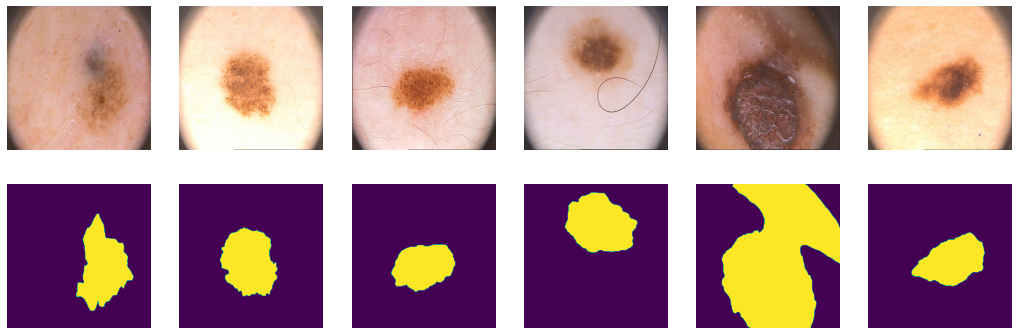

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Деление на train/val/test

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


In [ ]:
X_tr_tensor = torch.tensor(X[tr], device=DEVICE).transpose(1, 3)
X_val_tensor = torch.tensor(X[val], device=DEVICE).transpose(1, 3)
X_ts_tensor = torch.tensor(X[ts], device=DEVICE).transpose(1, 3)

Y_tr_tensor = torch.tensor(Y[tr], device=DEVICE)
Y_val_tensor = torch.tensor(Y[val], device=DEVICE)
Y_ts_tensor = torch.tensor(Y[ts], device=DEVICE)

In [ ]:
def IOU(X, Y):
    a = X.squeeze(0).squeeze(0).cpu().detach().numpy().transpose() > 0
    b = np.array(Y.cpu().numpy(), dtype=bool)
    overlap = a * b
    union = a + b

    iou = overlap.sum()/float(union.sum())
    return iou

In [ ]:
def score(model, X, Y):
    # Суммарный IOU по датасету
    sum_metric = 0
    for i in range(50):
        sum_metric += IOU(model(X[i][None, ...]), Y[i])
    return sum_metric / 50

In [ ]:
class DoubleConv(nn.Module):
    # Блок из двух сверток для U-Net
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Блоки, идущие вниз
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Блоки, идущие вверх
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Горлышко посередине
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, sheduler, num_epochs):
    
    best_model = copy.deepcopy(model.state_dict())
    best_score = -1

    for epoch in range(num_epochs):
        
        for phase in ('train', 'val'):
            if phase == 'train':
                model.train()
                train_loss = 0
            else:
                model.eval()
                val_loss = 0
            
            # Используем бачи по 5 элементов
            for i in range(0, 100, 5):
                if phase == 'train':
                    X_batch = X_tr_tensor[i:i+5, ...].to(DEVICE)
                    y_batch = Y_tr_tensor[i:i+5, None].to(DEVICE)
                else:
                    if i > 45:
                        break
                    X_batch = X_val_tensor[i:i+5, ...].to(DEVICE)
                    y_batch = Y_val_tensor[i:i+5, None].to(DEVICE)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            
                if phase == 'train':
                    train_loss += loss.item()
                else:
                    val_loss += loss.item()

            if phase == 'train':
                sheduler.step()

            if phase == 'val':
                iou = score(model, X_val_tensor, Y_val_tensor)
                print(f'epoch = {epoch + 1}, train_loss = {train_loss}, val_loss = {val_loss}, iou = {iou}')
                if iou > best_score:
                    best_score = iou
                    best_model = copy.deepcopy(model.state_dict())
    
    model.load_state_dict(best_model)
    return model

In [ ]:
model = train_model(model, loss_fn, optimizer, sheduler, 15)

epoch = 1, train_loss = 11.171821653842926, val_loss = 11.706071496009827, iou = 0.40188856429507075
epoch = 2, train_loss = 9.93723949790001, val_loss = 5.522691607475281, iou = 0.5564177558391639
epoch = 3, train_loss = 9.577422052621841, val_loss = 4.693116307258606, iou = 0.4693354468412905
epoch = 4, train_loss = 9.21021768450737, val_loss = 4.517591029405594, iou = 0.5849302636481889
epoch = 5, train_loss = 9.109986692667007, val_loss = 4.610787630081177, iou = 0.583984004499894
epoch = 6, train_loss = 9.002989739179611, val_loss = 4.607820808887482, iou = 0.5919086088463836
epoch = 7, train_loss = 8.875612884759903, val_loss = 4.390208721160889, iou = 0.623149703195956
epoch = 8, train_loss = 8.813574820756912, val_loss = 4.347671210765839, iou = 0.6269925854881869
epoch = 9, train_loss = 8.771081447601318, val_loss = 4.311029016971588, iou = 0.6327177868053117
epoch = 10, train_loss = 8.741025477647781, val_loss = 4.298944890499115, iou = 0.6348746578504696
epoch = 11, train_lo

Сравнение выхода модели с истинными данными

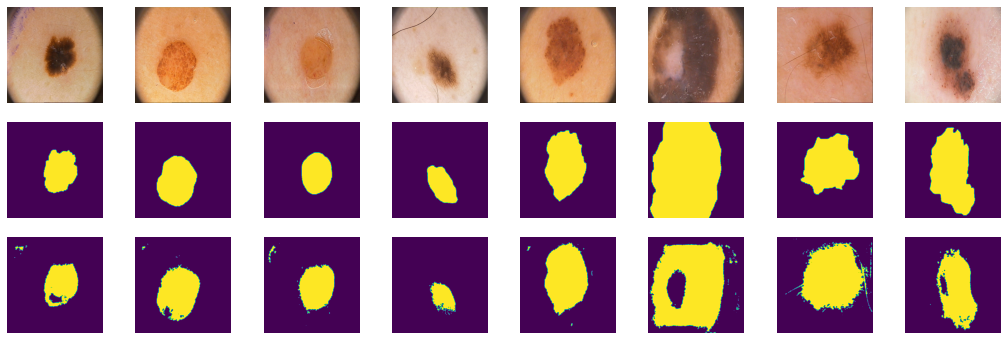

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(8):
    plt.subplot(3, 8, i+1)
    plt.axis("off")
    plt.imshow(X_ts_tensor[i].cpu().numpy().transpose())

    plt.subplot(3, 8, i+9)
    plt.axis("off")
    plt.imshow(Y_ts_tensor[i].cpu().numpy())
    
    plt.subplot(3, 8, i+17)
    plt.axis("off")
    plt.imshow(model(X_ts_tensor[i][None, ...]).squeeze(0).squeeze(0).cpu().detach().numpy().transpose() > 0)
plt.show();

Финальный скор

In [ ]:
score(model, X_ts_tensor, Y_ts_tensor)

0.6746120853234149